In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('dados_limpos.csv')
df

,match_name,player-team,map,winner,rating,acs,kast,adr,hs,fk,fd
0,-140 vs Oden Kozou to Sekai no Otokotachi,-140,Haven,Oden Kozou to Sekai no Otokotachi,3.73,894.0,3.07,597.0,1.61,7.0,10.0
1,-140 vs Oden Kozou to Sekai no Otokotachi,Oden Kozou to Sekai no Otokotachi,Haven,Oden Kozou to Sekai no Otokotachi,6.02,1123.0,3.98,700.0,1.49,10.0,7.0
2,-140 vs Oni ni Kanabou,-140,Bind,Oni ni Kanabou,3.31,849.0,2.68,551.0,1.43,7.0,9.0
3,-140 vs Oni ni Kanabou,Oni ni Kanabou,Bind,Oni ni Kanabou,6.42,1251.0,3.88,807.0,1.33,9.0,7.0
4,0 Training vs İstanbul Wildcats Female,0 Training,Fracture,0 Training,5.94,1032.0,3.90,695.0,0.79,13.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...
46923,İstanbul Wildcats vs w0wClan,w0wClan,Icebox,İstanbul Wildcats,5.18,1122.0,3.68,757.0,1.48,16.0,12.0
46924,świeca vs ownage,ownage,Bind,świeca,3.17,834.0,2.95,494.0,0.92,6.0,11.0
46925,świeca vs ownage,świeca,Ascent,świeca,5.07,1070.0,4.00,655.0,1.15,12.0,11.0
46926,świeca vs ownage,ownage,Ascent,świeca,5.04,1042.0,3.57,700.0,0.91,11.0,12.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46928 entries, 0 to 46927
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   match_name   46928 non-null  object 
 1   player-team  46928 non-null  object 
 2   map          46928 non-null  object 
 3   winner       46928 non-null  object 
 4   rating       46928 non-null  float64
 5   acs          46928 non-null  float64
 6   kast         46928 non-null  float64
 7   adr          46928 non-null  float64
 8   hs           46928 non-null  float64
 9   fk           46928 non-null  float64
 10  fd           46928 non-null  float64
dtypes: float64(7), object(4)
memory usage: 3.9+ MB


In [5]:
# Vamos reestruturar os dados para ter uma linha por partida com estatísticas de ambos os times
partidas_unicas = df['match_name'].unique()

dados_processados = []

for partida in partidas_unicas:
    dados_partida = df[df['match_name'] == partida]
    
    if len(dados_partida) != 2:  # Garantir que temos dados de ambos os times
        continue
        
    time1 = dados_partida.iloc[0]
    time2 = dados_partida.iloc[1]
    
    # Verificar qual time é o vencedor
    vencedor = 1 if time1['winner'] == time1['player-team'] else 2
    
    # Criar entrada para o modelo com os dados de ambos os times
    entrada = {
        'match_name': partida,
        'map': time1['map'],
        'team1_rating': time1['rating'],
        'team1_acs': time1['acs'],
        'team1_kast': time1['kast'],
        'team1_adr': time1['adr'],
        'team1_hs': time1['hs'],
        'team1_fk': time1['fk'],
        'team1_fd': time1['fd'],
        'team2_rating': time2['rating'],
        'team2_acs': time2['acs'],
        'team2_kast': time2['kast'],
        'team2_adr': time2['adr'],
        'team2_hs': time2['hs'],
        'team2_fk': time2['fk'],
        'team2_fd': time2['fd'],
        'winner': vencedor  # 1 para time1, 2 para time2
    }
    
    dados_processados.append(entrada)

# Converter para DataFrame
df_processado = pd.DataFrame(dados_processados)

In [6]:
df_processado

,match_name,map,team1_rating,team1_acs,team1_kast,team1_adr,team1_hs,team1_fk,team1_fd,team2_rating,team2_acs,team2_kast,team2_adr,team2_hs,team2_fk,team2_fd,winner
0,-140 vs Oden Kozou to Sekai no Otokotachi,Haven,3.73,894.0,3.07,597.0,1.61,7.0,10.0,6.02,1123.0,3.98,700.0,1.49,10.0,7.0,2
1,-140 vs Oni ni Kanabou,Bind,3.31,849.0,2.68,551.0,1.43,7.0,9.0,6.42,1251.0,3.88,807.0,1.33,9.0,7.0,2
2,0 Training vs İstanbul Wildcats Female,Fracture,5.94,1032.0,3.90,695.0,0.79,13.0,8.0,4.23,918.0,3.20,609.0,1.44,8.0,13.0,1
3,100 Thieves vs Eclectiq,Split,8.27,1317.0,4.54,836.0,1.16,10.0,3.0,1.88,712.0,2.24,488.0,0.91,3.0,10.0,1
4,100 Thieves vs GunsForHire,Split,6.78,1173.0,4.13,747.0,1.35,10.0,6.0,3.19,758.0,2.39,512.0,1.00,6.0,10.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,wicket berg vs Foxy Araikordai,Icebox,6.51,1193.0,4.28,724.0,1.30,14.0,4.0,3.41,790.0,2.61,456.0,1.37,4.0,14.0,1
2075,xyz vs HOG RIDERS,Breeze,3.84,841.0,2.74,587.0,1.70,8.0,11.0,6.25,1161.0,4.05,758.0,0.94,11.0,8.0,2
2076,İstanbul Wildcats Female vs Daycare,Ascent,4.99,1002.0,3.52,682.0,1.12,16.0,18.0,5.34,1057.0,3.69,706.0,1.00,18.0,16.0,1
2077,İstanbul Wildcats Female vs GeeKay Esports Cherry,Bind,4.17,961.0,3.44,691.0,1.12,12.0,11.0,5.96,1093.0,3.87,728.0,1.23,11.0,12.0,2


Acurácia do modelo: 0.95

Relatório de classificação:
              precision    recall  f1-score   support

           1       0.95      0.95      0.95       444
           2       0.94      0.95      0.94       388

    accuracy                           0.95       832
   macro avg       0.95      0.95      0.95       832
weighted avg       0.95      0.95      0.95       832


Importância das features:
team1_rating: 0.2696
team2_rating: 0.2345
team1_acs: 0.1428
team2_acs: 0.0877
team2_adr: 0.0729
team2_kast: 0.0693
team1_adr: 0.0349
team1_kast: 0.0310
team2_fk: 0.0121
team2_fd: 0.0100
team2_hs: 0.0096
team1_hs: 0.0095
team1_fd: 0.0093
team1_fk: 0.0068


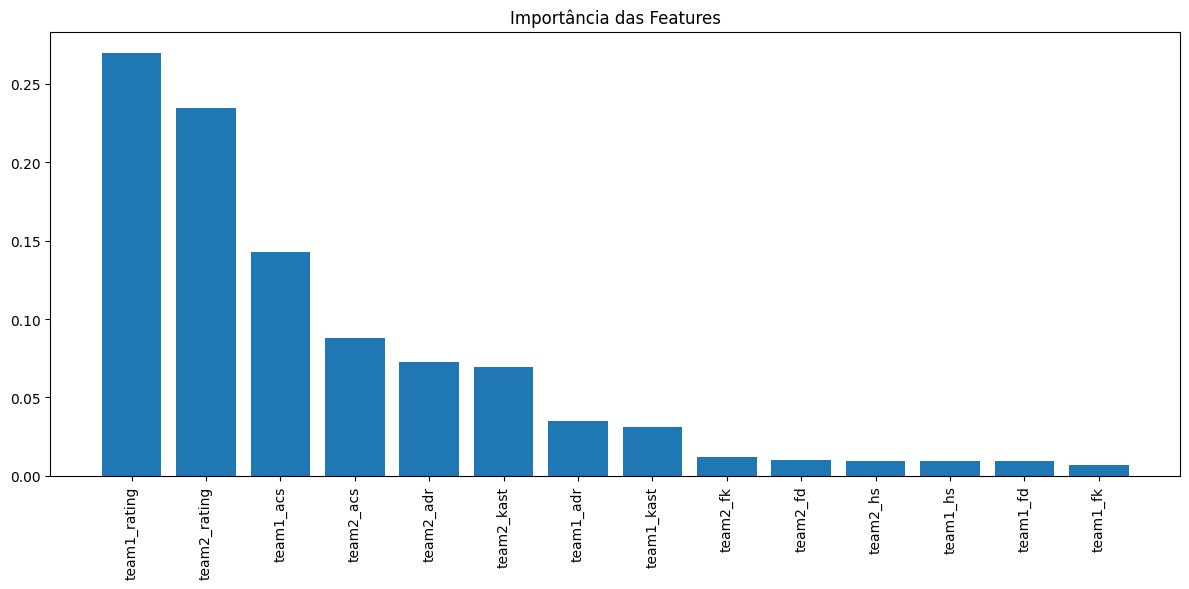

In [14]:
# Separar features e target
X = df_processado.drop(['match_name', 'map', 'winner'], axis=1)
y = df_processado['winner']

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.4, random_state=42)


# Criar e treinar o modelo
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# Avaliar o modelo
y_pred = modelo.predict(X_test)
acuracia = accuracy_score(y_test, y_pred)

print(f"Acurácia do modelo: {acuracia:.2f}")
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred))

# Analisar importância das features
importancias = modelo.feature_importances_
features = X.columns

indices = np.argsort(importancias)[::-1]
print("\nImportância das features:")
for i in range(len(features)):
    print(f"{features[indices[i]]}: {importancias[indices[i]]:.4f}")

# Visualizar importância das features
plt.figure(figsize=(12, 6))
plt.title('Importância das Features')
plt.bar(range(X.shape[1]), importancias[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [15]:
dados_time1 = {
        'rating': 4.5,
        'acs': 950,
        'kast': 3.2,
        'adr': 600,
        'hs': 1.4,
        'fk': 8,
        'fd': 6
    }
    
dados_time2 = {
    'rating': 5.8,
    'acs': 1100,
    'kast': 3.7,
    'adr': 680,
    'hs': 1.3,
    'fk': 9,
    'fd': 7
}

dados_combinados = {
    'team1_rating': dados_time1['rating'],
    'team1_acs': dados_time1['acs'],
    'team1_kast': dados_time1['kast'],
    'team1_adr': dados_time1['adr'],
    'team1_hs': dados_time1['hs'],
    'team1_fk': dados_time1['fk'],
    'team1_fd': dados_time1['fd'],
    'team2_rating': dados_time2['rating'],
    'team2_acs': dados_time2['acs'],
    'team2_kast': dados_time2['kast'],
    'team2_adr': dados_time2['adr'],
    'team2_hs': dados_time2['hs'],
    'team2_fk': dados_time2['fk'],
    'team2_fd': dados_time2['fd']
}

# Converter para DataFrame
df_novo = pd.DataFrame([dados_combinados])

# Normalizar os dados
dados_normalizados = scaler.transform(df_novo)

# Fazer a previsão
previsao = modelo.predict(dados_normalizados)[0]
probabilidades = modelo.predict_proba(dados_normalizados)[0]
print(previsao)
print(probabilidades)

2
[0.01 0.99]
